# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator,TransformerMixin
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle
import boto3
import os
from flask import Flask, jsonify, request



One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [2]:
# Load the data
df = pd.read_csv('/Users/t895976/Desktop/LHL/mini-project-IV/data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# find missing values
null_cols = df.columns[df.isnull().any()]
print(df[null_cols].isnull().sum())

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64


Look at some basic statistics for numerical variables.

In [5]:
# get basic stats for numerical columns
#numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)
2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?
3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.



Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [6]:
num_with_credit_history = df['Credit_History'].notnull().sum()
print(f"Number of applicants with a Credit_History: {num_with_credit_history}")

Number of applicants with a Credit_History: 564


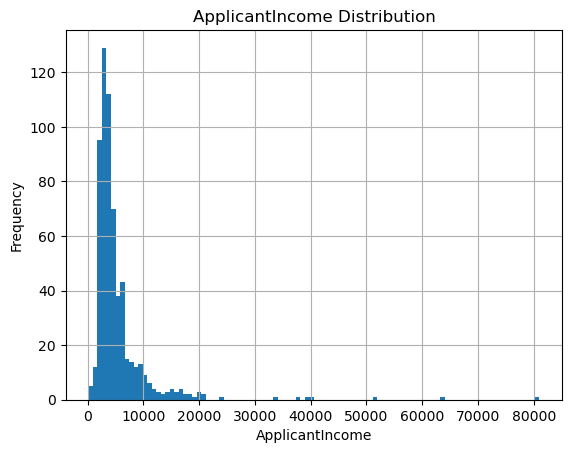

In [7]:
# plot the ApplicantIncome distribution
df['ApplicantIncome'].hist(bins=100)
plt.xlabel('ApplicantIncome')
plt.ylabel('Frequency')
plt.title('ApplicantIncome Distribution')
plt.show()

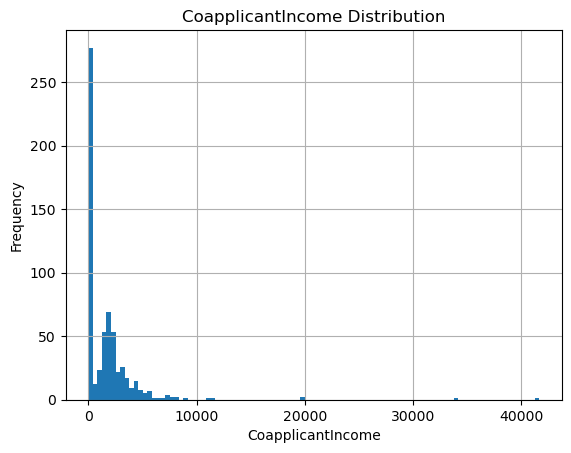

In [8]:
# plot the CoapplicantIncome distribution
df['CoapplicantIncome'].hist(bins=100)
plt.xlabel('CoapplicantIncome')
plt.ylabel('Frequency')
plt.title('CoapplicantIncome Distribution')
plt.show()

Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

In [9]:
# find skewness of ApplicantIncome
app_inc_skewness = df['ApplicantIncome'].skew()

print(f"Skewness of ApplicantIncome: {app_inc_skewness}")

Skewness of ApplicantIncome: 6.539513113994625


In [10]:
# find skewness of ApplicantIncome
app_inc_skewness = df['CoapplicantIncome'].skew()

print(f"Skewness of CoapplicantIncome: {app_inc_skewness}")

Skewness of CoapplicantIncome: 7.491531216657306


### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



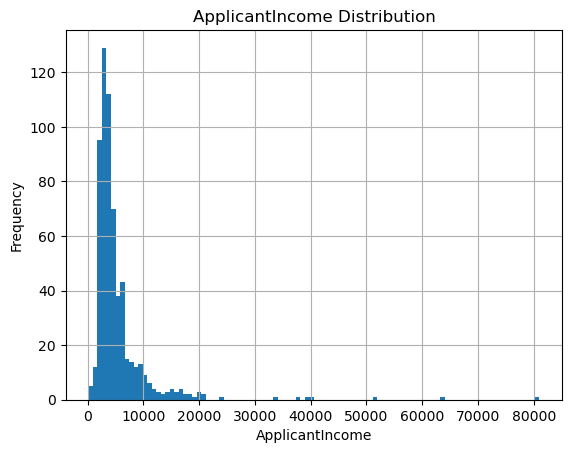

In [11]:
# plot the ApplicantIncome distribution
df['ApplicantIncome'].hist(bins=100)
plt.xlabel('ApplicantIncome')
plt.ylabel('Frequency')
plt.title('ApplicantIncome Distribution')
plt.show()


Look at box plots to understand the distributions. 

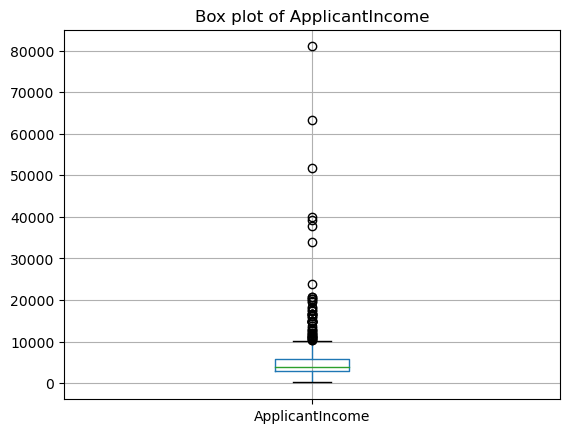

In [12]:
# create boxplot of ApplicantIncome
df.boxplot(column='ApplicantIncome')
plt.title('Box plot of ApplicantIncome')
plt.show()

Look at the distribution of income segregated  by `Education`

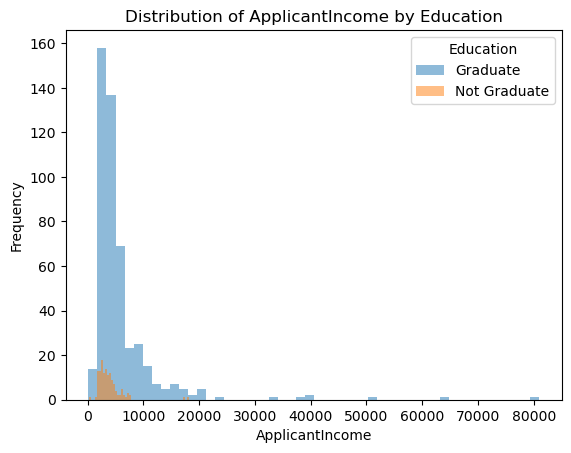

In [13]:
# create a histogram of ApplicantIncome for each Education group
df.groupby('Education')['ApplicantIncome'].plot(kind='hist', alpha=0.5, bins=50)
plt.legend(title='Education')
plt.xlabel('ApplicantIncome')
plt.ylabel('Frequency')
plt.title('Distribution of ApplicantIncome by Education')
plt.show()

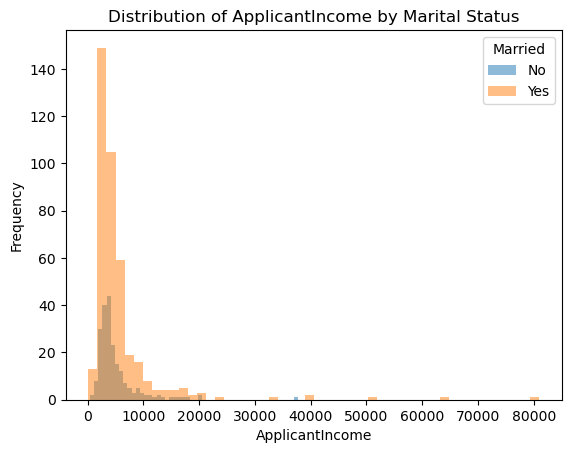

In [14]:
# create a histogram of ApplicantIncome for each Education group
df.groupby('Married')['ApplicantIncome'].plot(kind='hist', alpha=0.5, bins=50)
plt.legend(title='Married')
plt.xlabel('ApplicantIncome')
plt.ylabel('Frequency')
plt.title('Distribution of ApplicantIncome by Marital Status')
plt.show()

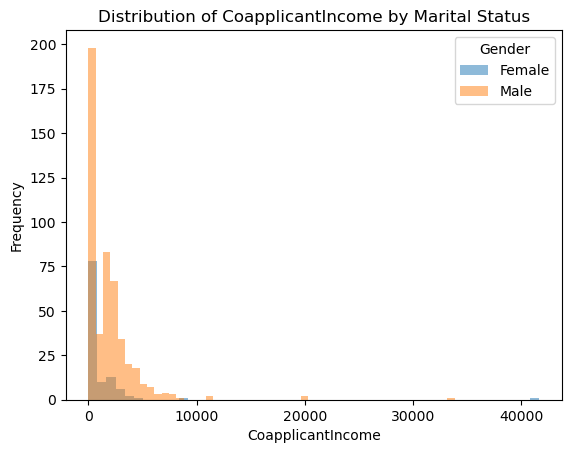

In [15]:
# create a histogram of ApplicantIncome for each Education group
df.groupby('Gender')['CoapplicantIncome'].plot(kind='hist', alpha=0.5, bins=50)
plt.legend(title='Gender')
plt.xlabel('CoapplicantIncome')
plt.ylabel('Frequency')
plt.title('Distribution of CoapplicantIncome by Marital Status')
plt.show()

Look at the histogram and boxplot of LoanAmount

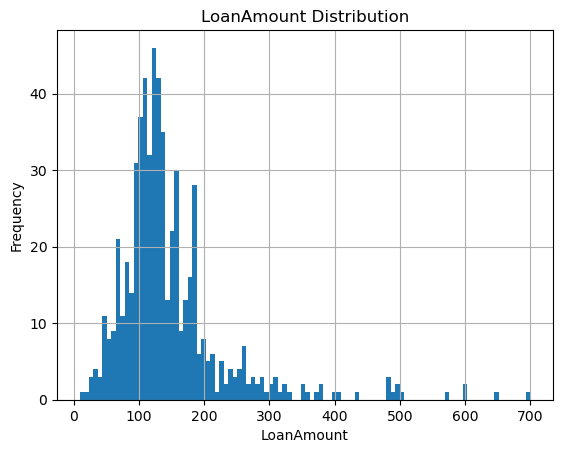

In [16]:
# plot the ApplicantIncome distribution
df['LoanAmount'].hist(bins=100)
plt.xlabel('LoanAmount')
plt.ylabel('Frequency')
plt.title('LoanAmount Distribution')
plt.show()

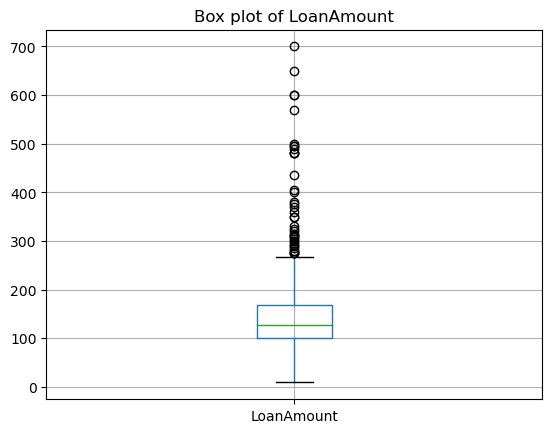

In [17]:
# create boxplot of ApplicantIncome
df.boxplot(column='LoanAmount')
plt.title('Box plot of LoanAmount')
plt.show()

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

In [18]:
# create a pivot table on Education and Property_Area
table = pd.pivot_table(df, values='LoanAmount', index=['Education'], columns=['Property_Area'], aggfunc='mean')
print(table)

Property_Area       Rural   Semiurban       Urban
Education                                        
Graduate       163.023622  152.587912  148.480769
Not Graduate   122.543478  117.478261  114.200000


In [19]:
# create a pivot table on Education and Property_Area
table = pd.pivot_table(df, values='ApplicantIncome', index=['Education'], columns=['Property_Area'], aggfunc='mean')
print(table)

Property_Area        Rural    Semiurban       Urban
Education                                          
Graduate       6162.687023  5699.994652  5792.32716
Not Graduate   3893.104167  3634.739130  3802.22500


In [20]:
# create a pivot table on Education and Property_Area
table = pd.pivot_table(df, values='ApplicantIncome', index=['Education'], columns=['Self_Employed'], aggfunc='mean')
print(table)

Self_Employed           No          Yes
Education                              
Graduate       5504.203085  7735.507692
Not Graduate   3457.108108  6024.647059


In [21]:
# create a pivot table on Education and Property_Area
table = pd.pivot_table(df, values='ApplicantIncome', index=['Education'], columns=['Credit_History'], aggfunc='mean')
print(table)

Credit_History          0.0          1.0
Education                               
Graduate        6632.873016  5816.568421
Not Graduate    3369.192308  3866.357895


## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



In [7]:
# find missing values
null_cols = df.columns[df.isnull().any()]
print(df[null_cols].isnull().sum())

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64


Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [8]:
# impute missing values in LoanAmount column with mean of LoanAmount
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].max())
df['Credit_History'] = df['Credit_History'].fillna(0)

In [9]:
# define options for filling missing values in the Gender column
options = ['Male', 'Female']

# generate random values to fill missing values in Gender column
rand_fill = lambda x: random.choice(options) if pd.isnull(x) else x
df['Gender'] = df['Gender'].apply(rand_fill)


In [10]:
# define options for filling missing values in the Gender column
options = ['No', 'Yes']

# generate random values to fill missing values in Gender column
rand_fill = lambda x: random.choice(options) if pd.isnull(x) else x
df['Married'] = df['Married'].apply(rand_fill)

# generate random values to fill missing values in Gender column
rand_fill = lambda x: random.choice(options) if pd.isnull(x) else x
df['Self_Employed'] = df['Self_Employed'].apply(rand_fill)


In [11]:
# convert the values in the Dependents column to a numeric type
df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

# fill missing values with the maximum value in the column
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].max())


In [12]:
# find missing values
null_cols = df.columns[df.isnull().any()]
print(df[null_cols].isnull().sum())

Series([], dtype: float64)


### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

In [28]:
# combine ApplicantIncome and CoapplicantIncome columns as total income
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# apply log transformation to TotalIncome column
df['TotalIncome'] = np.log(df['TotalIncome'])

# display the first few rows of the transformed DataFrame
print(df.head())

    Loan_ID Gender Married  Dependents     Education Self_Employed  \
0  LP001002   Male      No         0.0      Graduate            No   
1  LP001003   Male     Yes         1.0      Graduate            No   
2  LP001005   Male     Yes         0.0      Graduate           Yes   
3  LP001006   Male     Yes         0.0  Not Graduate            No   
4  LP001008   Male      No         0.0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0  146.412162             360.0   
1             4583             1508.0  128.000000             360.0   
2             3000                0.0   66.000000             360.0   
3             2583             2358.0  120.000000             360.0   
4             6000                0.0  141.000000             360.0   

   Credit_History Property_Area Loan_Status  TotalIncome  
0             1.0         Urban           Y     8.674026  
1             1.0         Rural   

In [29]:
# apply log transformation to LoanAmount column
df['LoanAmount'] = np.log(df['LoanAmount'])

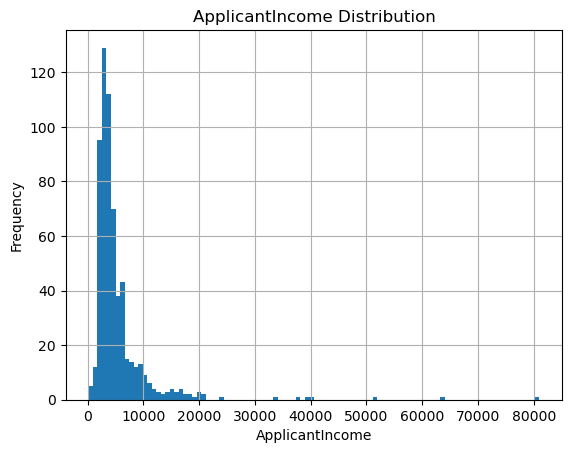

In [30]:
# plot the ApplicantIncome distribution
df['ApplicantIncome'].hist(bins=100)
plt.xlabel('ApplicantIncome')
plt.ylabel('Frequency')
plt.title('ApplicantIncome Distribution')
plt.show()

Combine both incomes as total income and take a log transformation of the same.

## 4. Building a Predictive Model

In [4]:
# drop Loan_ID column
df.drop('Loan_ID', axis=1, inplace=True)
#df.drop('Loan_ID', axis=1, inplace=True)

In [32]:
# display the first few rows of the transformed DataFrame
print(df.head())

  Gender Married  Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No         0.0      Graduate            No             5849   
1   Male     Yes         1.0      Graduate            No             4583   
2   Male     Yes         0.0      Graduate           Yes             3000   
3   Male     Yes         0.0  Not Graduate            No             2583   
4   Male      No         0.0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0    4.986426             360.0             1.0   
1             1508.0    4.852030             360.0             1.0   
2                0.0    4.189655             360.0             1.0   
3             2358.0    4.787492             360.0             1.0   
4                0.0    4.948760             360.0             1.0   

  Property_Area Loan_Status  TotalIncome  
0         Urban           Y     8.674026  
1         Rural           N   

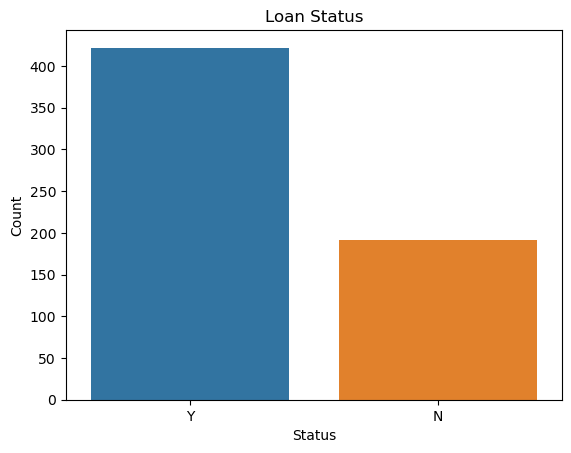

In [33]:
# load your dataset and store it in a variable (e.g. df)

# create a bar plot of Loan_Status
sns.countplot(x='Loan_Status', data=df)

# set the plot title and axis labels
plt.title('Loan Status')
plt.xlabel('Status')
plt.ylabel('Count')

# display the plot
plt.show()

In [34]:
# encode categorical variables
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Married'] = le.fit_transform(df['Married'])
df['Dependents'] = le.fit_transform(df['Dependents'])
df['Education'] = le.fit_transform(df['Education'])
df['Self_Employed'] = le.fit_transform(df['Self_Employed'])
df['Property_Area'] = le.fit_transform(df['Property_Area'])
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])

In [5]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [13]:
# Define the features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing steps for the categorical and numerical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features),
        ('log', 'passthrough', ['ApplicantIncome', 'CoapplicantIncome']),
    ])

# Define the classifier
clf = RandomForestClassifier(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf)])

# Define the parameter grid for the classifier
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Make predictions on the test data using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

# Save the trained model as a pickle file
joblib.dump(grid_search.best_estimator_, 'loan_model.pkl')


Best parameters:  {'classifier__max_depth': 10, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best score:  0.7311069882498454
              precision    recall  f1-score   support

           N       0.75      0.42      0.54        43
           Y       0.75      0.93      0.83        80

    accuracy                           0.75       123
   macro avg       0.75      0.67      0.68       123
weighted avg       0.75      0.75      0.73       123



['loan_model.pkl']

Try paramater grid search to improve the results

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [14]:
# Load new data into a DataFrame
new_data = pd.DataFrame({
    'Gender': ['Male', 'Female', 'Male'],
    'Married': ['Yes', 'No', 'Yes'],
    'Dependents': ['0', '1', '2'],
    'Education': ['Graduate', 'Not Graduate', 'Graduate'],
    'Self_Employed': ['No', 'Yes', 'No'],
    'ApplicantIncome': [5000, 8000, 10000],
    'CoapplicantIncome': [2000, 0, 4000],
    'LoanAmount': [200, 250, 300],
    'Loan_Amount_Term': [360, 360, 360],
    'Credit_History': [1, 0, 1],
    'Property_Area': ['Urban', 'Rural', 'Semiurban'],
    'TotalIncome': [7000, 8000, 14000]
})

# Make predictions using the fitted pipeline
y_pred = grid_search.best_estimator_.predict(new_data)

# Print the predictions
print(y_pred)

['Y' 'N' 'Y']


## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

In [19]:
# Save the model as a pickle file
with open('loan_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [31]:
# Set AWS access keys
access_key = ''
secret_key = ''

# Create an S3 client
s3 = boto3.client('s3', aws_access_key_id=access_key, aws_secret_access_key=secret_key)

# Use the S3 client to list buckets
response = s3.list_buckets()

# Print the names of the S3 buckets
for bucket in response['Buckets']:
    print(bucket['Name'])

loan-model-bucket-897475


In [32]:
# Upload the pickle file to an S3 bucket
#s3 = boto3.client('s3')
s3.upload_file('loan_model.pkl', 'loan-model-bucket-897475', 'loan_model.pkl')

In [33]:
# Load the model from the S3 bucket
#s3 = boto3.client('s3')
s3.download_file('loan-model-bucket-897475', 'loan_model.pkl', '/tmp/model.pkl')
with open('/tmp/model.pkl', 'rb') as f:
    model = pickle.load(f)

In [34]:
# Initialize the Flask application
app = Flask(__name__)

# Define the endpoint to make predictions
@app.route('/predict', methods=['POST'])
def predict():
    # Get the input data from the request
    data = request.get_json()

    # Perform any necessary preprocessing on the input data
    # ...

    # Make predictions using the trained model
    predictions = model.predict(data)

    # Return the predictions as a JSON response
    return jsonify({'predictions': predictions.tolist()})

# Start the Flask application
if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Mar/2023 16:26:27] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [04/Mar/2023 16:26:27] "GET /favicon.ico HTTP/1.1" 404 -
